# TP07 - Language Modeling

- Part A is a short introduction to language modeling with Markov chains.
- Part B is optional, conceptually easy, but more challenging in terms of programming.
- Part C is the most interesting, and the goal of this session, adjust your time budget accordingly.

In [1]:
!pip install --quiet "git+https://gitlab.com/robindar/dl-scaman_checker.git"
from dl_scaman_checker import TP07
TP07.check_install()

[DONE] Install ok. Version is v0.4.1


In [2]:
filename = "input.txt"
TP07.download_tinyshakespeare(filename)

[DONE] Download ok, ETag matches expectation. File available at 'input.txt'


In [3]:
import torch, torch.nn as nn, torch.nn.functional as F, numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Part A - Language modeling basics

### A.1 - Predictive models for textual data

Our goal is to generate random text. To this end, we will define a probability distribution
over "texts", such that we are able to sample from this distribution, and then optimize over
such distributions.

Let $\Sigma$ be a set, called the "alphabet".
A "text" of size $k \in \mathbb{N}$ is an element of $\Sigma^k$.
Define $X : \mathbb{N} \to \Sigma$ a sequence of random variables with a given distribution.
We model the probability of a text $t \in \Sigma^k$
as $$\mathbb{P}(t) = \mathbb{P}(X_{\leq k} = t) = \prod_{i \in [k]} \mathbb{P}(X_i = t_i \mid X_{< i} = t_{< i}) $$
For every distribution on sequences, this yields a simple way to sample: one character at a time.

We will represent these conditional distributions as a function
$f_i : \Sigma^i \to \mathbb{R}^\Sigma$ for $i \in \mathbb{N}$,
such that $$\mathbb{P}(X_i = s \,|\, X_{<i} = q) = \frac{ \exp\left(r_s\right) }{ \sum_{j \in \Sigma} \exp\left(r_j\right) } \quad\text{where}\quad r = f_i(q)$$
This transformation is implemented as `F.softmax` in PyTorch. The variable `r` is called the "logit".
Usually the function $f$ only depends on a finite number of previous characters, called the "block size" of the model.
For instance, a Markov chain has a block size of 1. This influences the computational cost of the model, but also the size of the context that it can take into account.

In [4]:
alphabet, train_data, val_data = TP07.read_from_file(filename)
vocab_size = len(alphabet.characters)
alphabet.characters, vocab_size

("\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz", 65)

In [5]:
train_data.shape, train_data.dtype

(torch.Size([1003854]), torch.int64)

In [6]:
train_size, val_size = [ TP07.human_readable_unit(len(d)) for d in (train_data, val_data) ]
print(f"Training: {train_size} chars, Validation: {val_size} chars")

Training: 1.0M chars, Validation: 112K chars


We provide the `Alphabet` class, which performs the encoding / decoding between strings and sequences of integers, with the functions `alphabet.encode` and `alphabet.decode`.

In [7]:
alphabet.encode("Lorem ipsum")

[24, 53, 56, 43, 51, 1, 47, 54, 57, 59, 51]

In [8]:
alphabet.decode([ 24, 53, 56, 43, 51 ])

'Lorem'

### A.2 - Sampling from a given language model

In [9]:
sample_model = TP07.SampleLogitModel(alphabet)

In [10]:
sample_model(alphabet.encode("brow"))

array([-1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
        9.5367386e-07, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
       -1.3815511e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
        1.2206073e+01, -1.3815511e+01, -1.3815511e+01, -1.3815511e+01,
      

Write the `prompt` function, which takes a logit-computation function $f$, a number of characters to sample, and a preprompt to initialize the sequence. Additionally, take a temperature parameter $T \in \mathbb{R}_+^*$, and sample from the logits $s \mapsto \frac{1}{T} f(s)$, such that in the limit $T \to +\infty$ it samples from the uniform distribution.

You can use the functions `F.softmax` and `torch.multinomial(p, num_samples=1)` for sampling.

In [11]:
def prompt(model, num_chars, preprompt="", temp=1.):
    ### your code here ###
    seq = alphabet.encode(preprompt)
    for _ in range(num_chars):
        seq = sample_next_char(model, seq, temp=temp)
    return alphabet.decode(seq)

def sample_next_char(model, seq, temp):
    assert temp > 0
    l = model(seq) / temp
    s = len(alphabet.characters)
    assert l.shape == (s,), f"Expected probabilities of shape {(s,)} but got {l.shape}"
    probs = F.softmax(torch.Tensor(l), dim=-1)
    idx_next = torch.multinomial(probs, num_samples=1)
    return seq + [ idx_next.item() ]

Generate a couple sentences (e.g. 80 characters) from the sample model, with the preprompts "quick" and with a non-sensical preprompt such as "sjdaklda". What do you notice when you increase the temperature ?

In [12]:
### you code here ###
preprompt = "quick"

for temp in reversed([ 1e5, 1e+2, 1e-0, 1e-2, 1e-4, 1e-6 ]):
    print(f"  --- T:{temp:+.1e} ---")
    print(prompt(sample_model, 80, preprompt, temp=temp))

  --- T:+1.0e-06 ---
quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog.
  --- T:+1.0e-04 ---
quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog.
  --- T:+1.0e-02 ---
quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog.
  --- T:+1.0e+00 ---
quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog.
  --- T:+1.0e+02 ---
quick MQ&sc  icPRE bysOvlrTMnycvTWHOFmTPyELqiN.lsKj:JY-yIL:$,l-TlHP$m.
T?rBR3E?Mmh.HQ
  --- T:+1.0e+05 ---
quickRRg,u&Lq GQ?JZ3GBEFbe-t:K
lo?3A-'
K,3TRA?TWkUEEOllF!UuN.OuLS;IIuQ?f- $EESEOsM
GK


### A.3 - Building a bigram model

For your first custom model, represent text with a Markov chain over the alphabet, where the probability of each character in the text depends only on the previous character. Use as transition matrix the empirical distribution of pairs of characters in the training data.

In [13]:
### your code here ###
vocab_size = len(alphabet.characters)
probs = np.ones((vocab_size, vocab_size), dtype=np.float64)
for i in range(len(train_data) - 1):
    probs[train_data[i], train_data[i+1]] += 1
logits = np.log(probs) # no need to renormalize, logits are defined up to a constant anyway

In [14]:
class StaticBigramModel():
    def __init__(self, logits):
        self.logits = logits

    def __call__(self, seq):
        if len(seq) == 0:
            return self.logits[0,:]
        return self.logits[seq[-1], :]

In [15]:
static_bigram_model = StaticBigramModel(logits)
print(prompt(static_bigram_model, 80))

Tathiturrey met ble flyowatid ar hry hishatheforsbathr:
He; a ue auspod t
I f ll


The result is quite disappointing, but the bigram model is also clearly an oversimplification of language, it would be very surprising if it could just spit out entire paragraphs from Shakespeare.
To assess performance in an easier setting, prompt this model with `"Jul"`, and see how often you can get it to auto-complete `"Juliet"` (a name which appears a lot in Shakespeare's plays). What happens if you lower the temperature too much ? How is this different from what happens when you prompt with `"the "` ?

In [16]:
np.mean([ prompt(static_bigram_model, 3, "Jul") == "Juliet" for _ in range(int(2e4)) ])

0.00015

In [17]:
prompt(static_bigram_model, 10, "Jul", 1e-8) # 'll' is a common pattern -> cycle of size 1

'Julllllllllll'

In [18]:
prompt(static_bigram_model, 25, "the ", 1e-8) # 'the ' is also very common -> cycle of size 4

'the the the the the the the t'

## Part B - N-Gram Language modeling (optional, advanced)

An $n$-gram model for $n \in \mathbb{N} \setminus \{0\}$ models text not with a Markov chain over the alphabet, but with a Markov chain over $n$-grams (tuples of $n$ consecutive characters).
It defines $Y : \mathbb{N} \to \Sigma^n$ the sequence $Y_i = (X_{i+j})_{j \in [n]}$
and constructs the distribution on $X$ from a transition probability matrix for $Y$.
This is a standard trick of Markov chains to depend on the previous $(n-1)$ events instead of only the last event.

Write your own $n$-gram model, which takes at initialization an integer $n \in \mathbb{N} \setminus \{0\}$ and the training data, then compute the empirical transition probabilities for $Y$. You should have a memory complexity of $(\#\Sigma)^n$.

A few tricks to help you deal with varying $n$:
- For `a` of type `np.ndarray`, the syntaxes `a[0,4,2]` and `a[tuple(0,4,2)]` are equivalent
- You can cast back and forth from list to tuples with `list(t)` and `tuple(l)`

To avoid dealing with preprompts that are too short, you can pad with leading space characters.

In [19]:
class StaticNGramModel():
    def __init__(self, n, train_data):
        self.n = n
        histsize = n-1
        logits = np.ones(tuple([vocab_size] * (histsize+1)), dtype=np.float32) * .01
        for i in range(len(train_data) - histsize):
            logits[tuple(train_data[i:i+histsize+1])] += 1
        self.logits = np.log(logits)

    def block_size(self):
        return self.n - 1

    def __call__(self, seq):
        if isinstance(seq, torch.Tensor):
            seq = seq.detach().numpy()
        if self.n == 1:
            return self.logits
        if len(seq) < self.n - 1:
            seq = alphabet.encode(' ') * (self.n - len(seq)) + list(seq)
        return self.logits[tuple(seq[-(self.n-1):])]

Compute the negative log-likelihood of the validation data under each such $n$-gram model with $n \in \{ 1, 2, 3, 4, 5 \}$. Add a method `model.block_size() == n-1` returning the maximal size of the context that your model can handle, to avoid a quadratic complexity in the likelihood computation. How do $5$-gram models compare to the previous bigram model on the "Juliet" test ? Does the generated text look better ?

In [20]:
def negloglikelihood(model, encoded_text):
    loss = 0
    for i in range(len(encoded_text)):
        l = model(encoded_text[i - model.block_size():i])
        probs = F.softmax(torch.tensor(l), dim=-1)
        loss += - torch.log(probs[encoded_text[i]]).item()
    return loss / len(encoded_text)

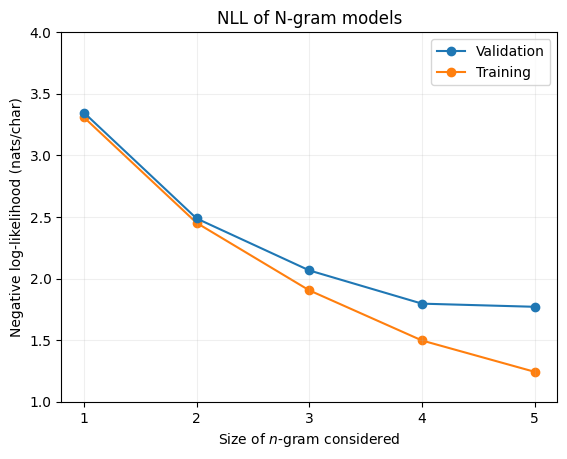

In [21]:
import matplotlib.pyplot as plt
nll, val_nll = [], []
n_list = [ 1, 2, 3, 4, 5 ]
for n in n_list:
    model = StaticNGramModel(n, train_data)
    nll.append(negloglikelihood(model, train_data))
    val_nll.append(negloglikelihood(model, val_data))
    del(model)
plt.xlabel(r"Size of $n$-gram considered")
plt.ylabel("Negative log-likelihood (nats/char)")
plt.grid(alpha=.2)
plt.plot(n_list, val_nll, '-o', label="Validation", zorder=2)
plt.plot(n_list, nll, '-o', label="Training", zorder=1)
plt.xticks(n_list)
plt.ylim(1,4)
plt.title("NLL of N-gram models")
plt.legend()
plt.show()

In [22]:
static_5gram_model = StaticNGramModel(5, train_data)
print( prompt(static_5gram_model, 80, "ROMEO:\n") )

ROMEO:
What cut of him had ballat
Of my confine
With our good false face of the bound; 


In [23]:
np.mean([ prompt(static_5gram_model, 3, "Jul") == "Juliet" for _ in range(int(1e4)) ])

0.8251

In [24]:
del(static_5gram_model)

## Part C - Language Modeling with Transformers

### C.1 - Training setup with bigram models

To prepare the setup for training language models by deep learning techniques, but before diving into the details of the model, let us re-build the bigram model in a learning-friendly manner,
and learn the transition probability matrix to maximize the log-likelihood of the training data, instead of computing the empirical probabilities manually.

We provide the `get_batch` and `train_model` functions.
We will compute predictions for all elements of the batch and for all timesteps at once, to speed up training.
This means for a batch size of 1 and an alphabet of size 65, the prediction for `xb.shape = (1, block_size)`
should have `model(xb).shape = (1, block_size, 65)`.
Read carefully the shape assertion.

In [25]:
def get_batch(data, batch_size = 16, block_size = 32):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [26]:
def train_model(model, optimizer, iterations=1):
    for _ in range(iterations):
        xb, yb = get_batch(train_data)
        logits = model(xb)
        assert logits.shape == (*yb.shape, len(alphabet.characters))
        logits = logits.view(-1, logits.shape[-1])
        loss = F.cross_entropy(logits, yb.view(-1))
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return model, optimizer

In [27]:
@torch.no_grad()
def estimate_negloglikelihood(model, data, eval_iters=250):
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(data)
        logits = model(X)
        logits = logits.view(-1, logits.shape[-1])
        loss = F.cross_entropy(logits, Y.view(-1))
        losses[k] = loss.item()
    model.train()
    return losses.mean()

Write the Bigram model as a trainable `torch.nn.Module`. Make sure it works with batches of shape `(batch_size, block_size)`, for which the forward function should return a tensor of shape `(batch_size, block_size, alphabet_size)`.

In [28]:
class Bigram(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.logits = nn.Parameter(torch.zeros((vocab_size, vocab_size)))

    def block_size(self):
        return 1

    def forward(self, idx):
        return self.logits[idx]

In [29]:
bigram_model = Bigram(len(alphabet.characters)).to(device)
print(f"Bigram model has {TP07.printable_parameter_count(bigram_model)} parameters")
optimizer = torch.optim.Adam(bigram_model.parameters(), lr=1e-2)

Bigram model has 4K parameters


In [30]:
for _ in range(5):
    bigram_model, optimizer = train_model(bigram_model, optimizer, iterations=100)
    train_loss, val_loss = [ estimate_negloglikelihood(bigram_model, data) for data in [ train_data, val_data ] ]
    print(f"train loss {train_loss:.4f}, val loss {val_loss:.4f}")

train loss 3.2425, val loss 3.2470
train loss 2.7989, val loss 2.8052
train loss 2.6277, val loss 2.6362
train loss 2.5577, val loss 2.5652
train loss 2.5174, val loss 2.5381


In [31]:
wrapped_bigram_model = lambda u: bigram_model(u)[-1]
print( prompt(wrapped_bigram_model, 100, preprompt="Jul", temp=1e-2) )

Julllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll


### C.2 - Advanced Language Models

Now let us build a GPT-like architecture.
We will use the causal / masked attention operation,
where the mask $M \in \{ 0 ,  1\}^{d \times d}$ is defined as $M_{i,j} = 1$ if and only if $i > j$.
$$ \operatorname{Attention} : X \in \mathbb{R}^{d \times d} \mapsto \left[ \dfrac{M_{i,j} \exp(X_{i,j}) }{ \sum_{k} M_{i,k} \exp(X_{i,k}) } \right]_{i,j} \in \mathbb{R}^{d \times d} $$
If you want use `F.softmax`, you may want to use the functions `Tensor.masked_fill` and `torch.tril` as well.
You can implement matrix multiplication with a learnable weight with `torch.nn.Linear(bias=false)`.

We write $B$ for the batch size, $T$ for the block size (or "timesteps"), and $C$ for the embedding dimension (or number of "channels").

1. Write a SelfAttention module implementing the operation with weights $K \in \mathbb{R}^{C \times d}$, $Q \in \mathbb{R}^{C \times d}$ and $V \in \mathbb{R}^{C \times d}$
$$ X \in \mathbb{R}^{B \times T \times C} \mapsto \left[ \operatorname{Attention}\left[\frac{(X_i \cdot K) \cdot (X_i \cdot Q)^T}{\sqrt{d}}\right] \cdot (X_i \cdot V) \right]_{i \in [B]} $$
We choose the variable `d` such that `d * num_heads = n_embd`, so the size is unchanged after going through a multi-head block.

3. Write a Multi-Head attention module computing the output of `num_heads` independent Self-Attention modules, then concatenating the result.

4. Write a Transformer module, computing the composition of a residual block with a multi-head attention module as residual,
    followed by a residual block with a two-layer ReLU-network for the residual. Add a layer norm at the start of each residual branch to avoid training instabilities.

In [32]:
class MaskedSelfAttention(nn.Module):
    def __init__(self, head_size, n_embd, block_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # (B,T,d)
        q = self.query(x) # (B,T,d)
        wei = q @ k.transpose(-2,-1) * C ** -0.5 # (B, T, d) @ (B, d, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        v = self.value(x) # (B,T,d)
        out = wei @ v # (B, T, T) @ (B, T, d) -> (B, T, d)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embd, block_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedSelfAttention(head_size, n_embd, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out


class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_head, block_size, hidden_size):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size)
        self.ffwd = nn.Sequential(
            nn.Linear(n_embd, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_embd),
        )
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


In [33]:
class LanguageModel(nn.Module):
    def __init__(self, n_embd, n_head, block_size, hidden_size, n_layers, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        blocks = [
            TransformerBlock(n_embd=n_embd,
                             n_head=n_head,
                             block_size=block_size,
                             hidden_size=hidden_size)
            for _ in range(n_layers) ]
        self.blocks = nn.Sequential(*blocks)
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self._block_size = block_size
    
    def block_size(self):
        return self._block_size
        
    def forward(self, idx):
        B, T = idx.shape
        # idx is a (B,T)-shaped LongTensor
        tok_emb = self.token_embedding_table(idx) # shape: (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # shape: (T,C)
        x = tok_emb + pos_emb # shape: (B,T,C)
        x = self.blocks(x) # shape: (B,T,C)
        x = self.ln_f(x) # shape: (B,T,C)
        logits = self.lm_head(x) # shape: (B,T,vocab_size)
        return logits

---

Initialize your language model, and train it repeatedly or tweak the hyperparameters and retrain, until you reach training losses below 1.5 nats/char. Prompt regularly during training to witness the evolution of the generated samples, but don't waste your time budget sampling too much if your training loss is above 1.75, you would get mostly unintelligible gibberish.

You should be able, by the end of the session, to get didaskalia in capitals with real Shakespeare character names followed by a colon, and vaguely old-english-sounding sentences separated by dots.

In [34]:
config = {
    "n_head": 4,
    "n_embd": 256,
    "hidden_size": 1024,
    "n_layers": 5,
    "block_size": 32,
    "vocab_size": len(alphabet.characters),
}
language_model = LanguageModel(**config).to(device)
paramcount = TP07.printable_parameter_count(language_model)
print(f"Language model has {paramcount} parameters")

optimizer = torch.optim.AdamW(language_model.parameters(), lr=1e-3)
total_iter = 0

Language model has 4.0M parameters


In [35]:
max_iters, eval_interval = 4000, 100

for iter in range(max_iters // eval_interval):
    language_model, optimizer = train_model(language_model, optimizer, iterations=eval_interval)
    train_loss, val_loss = [ estimate_negloglikelihood(language_model, data) for data in [ train_data, val_data ] ]
    total_iter += eval_interval
    print(f"step {total_iter:4d}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

step  100: train loss 2.4241, val loss 2.4362
step  200: train loss 2.2304, val loss 2.2400
step  300: train loss 2.1197, val loss 2.1569
step  400: train loss 2.0335, val loss 2.1056
step  500: train loss 1.9865, val loss 2.0598
step  600: train loss 1.9257, val loss 2.0157
step  700: train loss 1.8792, val loss 2.0011
step  800: train loss 1.8550, val loss 1.9631
step  900: train loss 1.8223, val loss 1.9497
step 1000: train loss 1.7931, val loss 1.9707
step 1100: train loss 1.7786, val loss 1.9252
step 1200: train loss 1.7472, val loss 1.8980
step 1300: train loss 1.7400, val loss 1.8752
step 1400: train loss 1.7163, val loss 1.8792
step 1500: train loss 1.7175, val loss 1.8762
step 1600: train loss 1.6982, val loss 1.8454
step 1700: train loss 1.6841, val loss 1.8228
step 1800: train loss 1.6657, val loss 1.8171
step 1900: train loss 1.6587, val loss 1.8199
step 2000: train loss 1.6449, val loss 1.8138
step 2100: train loss 1.6334, val loss 1.8132
step 2200: train loss 1.6294, val 

In [36]:
def lm_wrapper(m, u):
    u = torch.LongTensor(u)[None, -m.block_size():]
    return m(u)[0,-1,:]

print( prompt(lambda u: lm_wrapper(language_model, u), 250, preprompt="Jul") )

Julio
Those own keeps of the taffice ears.

CAPULET:
That sword howfe aid three and wantaged me,
That we London and majesty, alas; and this father but give!

GREMIO:
The safels: I will desire:
Honour, would by royal general of spectiless sincely me,
Wan


---